# Policy Gradient Methods
In this report we will implement $3$ policy gradient methods on the Gym environment FrozenLake. 
>"The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction.The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise."

Taken from: *[Gym Environment Documentations](https://gym.openai.com/envs/FrozenLake-v0/)*

This report is consist of 3 parts:

1.   **Helper Functions:** We begin by introducing some helper functions that would later on help us develop our methods.
2.   **Actor-Critic Methods:** In this section we develop the following Actor-Critic methods:
  1.   Actor-Critic with Eligibility Traces
  2.   Actor-Critic with Eligibility Traces only on the Critic but not the Actor
  3.   Actor-Critic Without any Eligibility Traces using one-step returns
3.   **Conclusion**




*   The actor is defined as:$$\pi(a|s,\theta)=softmax(h(s,a,\theta))$$
Where $h$ is the parameterized numerical preferences for each state-action pair. We define $h$ to be:
$$\theta^Tx(s,a)$$
Meaning that we define our preferences to be linear in features. Where the feature vector $x$ is simply given by:
$$[1,s,1,0,0,0]$$ $$[1,s,0,1,0,0]$$ $$[1,s,0,0,1,0]$$ $$[1,s,0,0,0,1]$$
For action 0, 1, 2, 3 respectively. The parameter $s$ here indicates the position of the character in the ForzenLake world. Note that under this definition we have:
$$\nabla_\theta\mathrm{ln}\pi(a|s,\theta)=x(s,a)-\sum_b\pi(b|s,\theta)x(s,b)$$
*   The critic function $\hat{v}(s,w)$ is given by $w^Tx(s)$ where $x(s)$ is the degree 1 polynomial feature of state $s$ and since each state in this problem is presented by a single number indicating the location of that state, we have: $$x(s)=[1,s]$$. Note that in this definition we have: $$\nabla_w\hat{v}(s,a)=x(s)$$






## 1.  Helper Functions
Below are some of the helper function we have developed to accommodate us with our task at hand.

In [0]:
! pip install gym

In [0]:
import random
import gym
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

### 1.1 Softmax Function:
Below is a Softmax function, specifically designed for our purposes in the ForzenLake problem. It takes in a feature vector $x$ and parameter vector $\theta$ then it returns the softmax of actions 0, 1, 2, 3 in an array.

In [0]:
def action4_softmax(x,theta):
  act0=np.exp(np.dot(np.append(x,np.array([1,0,0,0])),theta))
  act1=np.exp(np.dot(np.append(x,np.array([0,1,0,0])),theta))
  act2=np.exp(np.dot(np.append(x,np.array([0,0,1,0])),theta))
  act3=np.exp(np.dot(np.append(x,np.array([0,0,0,1])),theta))
  act_sum=act0+act1+act2+act3
  softmax_return=np.array([act0/act_sum,act1/act_sum,act2/act_sum,act3/act_sum,])
  return softmax_return

### 1.2  Picking an Action
The function below takes as input a vector of probabilities of actions, then based on those probabilities it picks an action and returns it.

In [0]:
def choos_action(x):
  y=np.zeros(x.size)
  a=random.random()
  for i in range(x.size):
    y[i]=np.sum(x[:i+1])
    if a<=y[i]:
      return i
    

### 1.3  Random Success Rate in FrozenLake
The code below, runs the environment $(FrozenLake)$ for $1000$ episodes while taking actions at random. It then reports what percentage of these episodes led to success. This is mainly for comparison purposes.

In [0]:
env = gym.make('FrozenLake-v0')
random_result=0;
for i_episode in range(1000):
  observation = env.reset()
  for t in range(200):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
      random_result+=reward
      break
random_result=(random_result*100)/1000

## 2.  Actor-Critic Methods
In this section we implement $3$ Actor-Critic methods for the environmnet of FrozenLake problem. These methods are:
1.   Actor-Critic with Eligibility Traces
2.   Actor-Critic with Eligibility Traces only on the Critic but not the Actor
3.   Actor-Critic Without any Eligibility Traces using one-step returns
The Actor and the Critic for all these algorithms are coded based on the definitions given at the beginning of the report. 

### 2.1  Actor-Critic with Eligibility Traces (episodic)
Below function is based on the algorithm in [Sattun and Barto](http://incompleteideas.net/book/the-book-2nd.html) page $274$. It runs the algorithm for one episode of the problem and then returns the parameters $\theta$ and $w$ at the end of that episode along with whether the episode was a success or failure.

In [0]:
def actor_critic_F(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w,environment):
  total_reward=0
  env = gym.make(environment).env
  observation_old = env.reset()
  z_theta=np.zeros(theta.size)
  z_w=np.zeros(w.size)
  I=1
  for t in range(200):
    x_old=np.append(1,observation_old)    
    action=choos_action(action4_softmax(x_old,theta))
    if action==0:
      action_f=np.array([1,0,0,0])
    if action==1:
      action_f=np.array([0,1,0,0])
    if action==2:
      action_f=np.array([0,0,1,0])
    if action==3:
      action_f=np.array([0,0,0,1])      
    observation_new, reward, done, info = env.step(action)
    total_reward=total_reward+reward
    x_new=np.append(1,observation_new)
    if done:
      delta=reward-np.dot(x_old,w)
    else:
      delta=reward+gamma*(np.dot(x_new,w))-np.dot(x_old,w)
    z_w=gamma*lambda_w*z_w+I*x_old
    z_theta=gamma*lambda_theta*z_theta+I*(np.append(x_old,action_f)-action4_softmax(x_old,theta)[0]*np.append(x_old,np.array([1,0,0,0]))
                                          -action4_softmax(x_old,theta)[1]*np.append(x_old,np.array([0,1,0,0]))
                                         -action4_softmax(x_old,theta)[2]*np.append(x_old,np.array([0,0,1,0]))
                                         -action4_softmax(x_old,theta)[3]*np.append(x_old,np.array([0,0,0,1])))
    w=w+alpha_w*delta*z_w
    theta=theta+alpha_theta*delta*z_theta
    I=gamma*I
    observation_old=observation_new
    if done:
      #print("Episode finished after {} timesteps".format(t+1))
      break
  return theta,w,total_reward

#### 2.1.1 Training
Below we are going to train our model for $300$ episodes on a set of $\gamma$ and $\lambda$ values indicated below. For each pair of $\gamma$ and $\lambda$ we will train our model $10$ times and then take an average to see what percentage of success the pair provides. The percentage of success is over the entire $300$ training steps and the model with the highest success percentage during training is preferable since it spends more time providing us with optimal solutions, rather than adjusting its parameters.

In [7]:
gamma=np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
lambda_theta=np.array([0.0005,0.005,0.05,0.1,0.2,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.8,0.9])
lambda_w=lambda_theta
alpha_theta=2**-9
alpha_w=2**-6
environment="FrozenLake-v0"
number_of_episods=300
number_of_runs_for_average=10
average_success_v0=np.zeros([number_of_runs_for_average,gamma.size,lambda_theta.size])

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  for g in range(gamma.size):
    for l in range (lambda_theta.size):
      t_r=0 
      theta=np.zeros(6)
      w=np.zeros(2)
      for i in range(number_of_episods):
        theta,w,temp=actor_critic_F(gamma[g],lambda_theta[l],lambda_w[l],alpha_theta,alpha_w,theta,w,environment)
        t_r+=temp
      t_r=(t_r*100)/number_of_episods
      average_success_v0[n,g,l]=t_r

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


#### 2.1.2 Plots
Below we will graph some plots that we later on refer to in the *Conclusion* section.

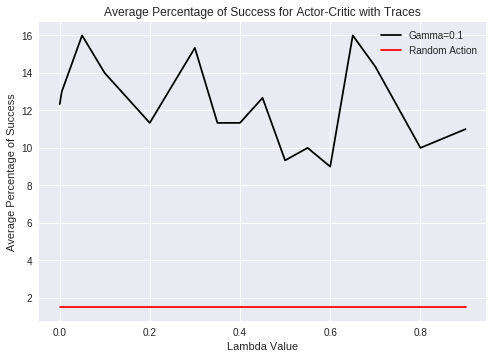

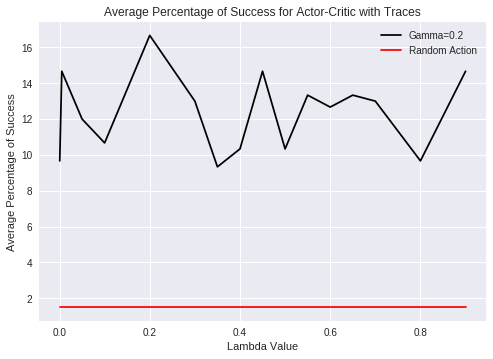

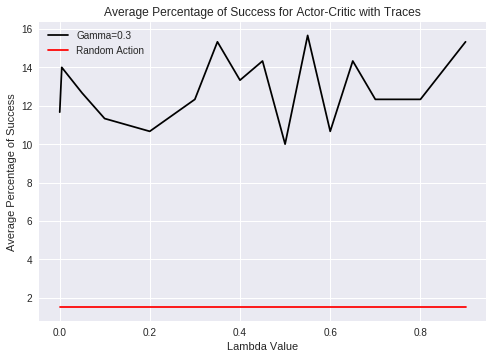

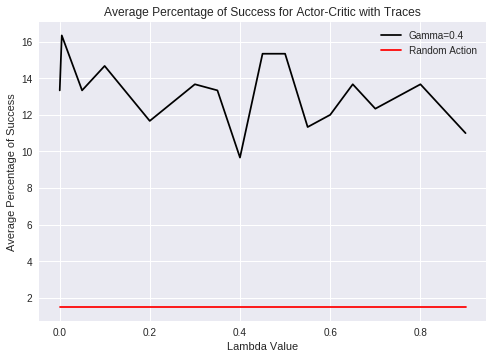

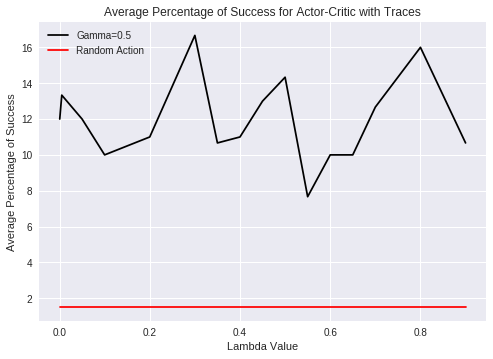

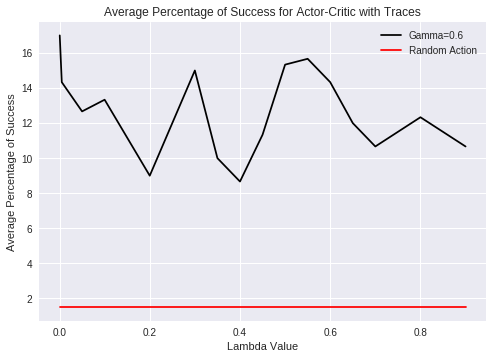

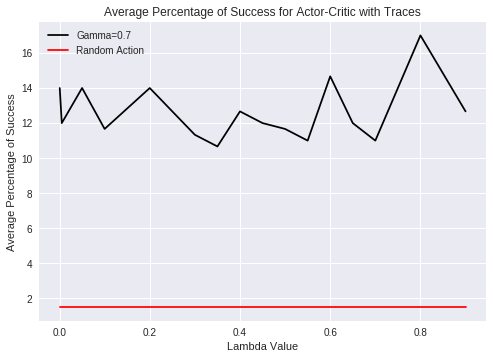

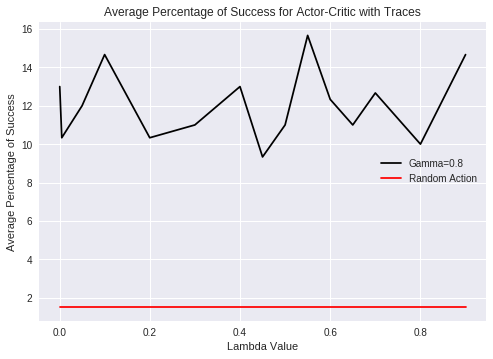

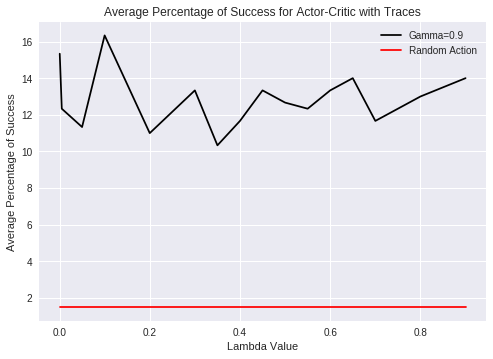

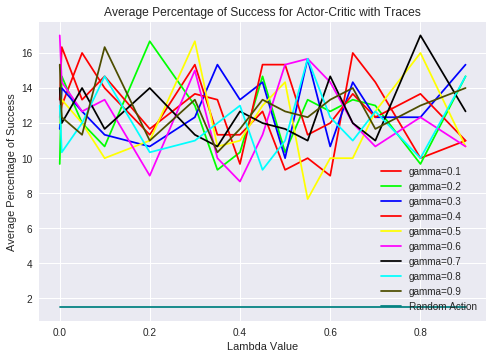

In [8]:
overall_avg_v0=np.zeros([gamma.size,lambda_theta.size])
rr=np.zeros(lambda_theta.size)+random_result

for g in range(gamma.size):
  overall_avg_v0=overall_avg_v0+average_success_v0[g,:,:]
overall_avg_v0/number_of_runs_for_average

for g in range(gamma.size):
  plt.figure()
  plt.plot(lambda_theta.flatten(),overall_avg_v0[g,:].flatten(),label="Gamma={}".format(gamma[g]),color=(0,0,0))
  plt.plot(lambda_theta.flatten(),rr.flatten(),label="Random Action",color=(1,0,0))
  plt.title('Average Percentage of Success for Actor-Critic with Traces')
  plt.xlabel('Lambda Value')
  plt.ylabel('Average Percentage of Success')
  plt.legend()
  plt.show()

plt.figure()
plt.plot(lambda_theta.flatten(),overall_avg_v0[0,:].flatten(),label="gamma={}".format(gamma[0]),color=(1,0,0))
plt.plot(lambda_theta.flatten(),overall_avg_v0[1,:].flatten(),label="gamma={}".format(gamma[1]),color=(0,1,0))
plt.plot(lambda_theta.flatten(),overall_avg_v0[2,:].flatten(),label="gamma={}".format(gamma[2]),color=(0,0,1))
plt.plot(lambda_theta.flatten(),overall_avg_v0[3,:].flatten(),label="gamma={}".format(gamma[3]),color=(1,0,0))
plt.plot(lambda_theta.flatten(),overall_avg_v0[4,:].flatten(),label="gamma={}".format(gamma[4]),color=(1,1,0))
plt.plot(lambda_theta.flatten(),overall_avg_v0[5,:].flatten(),label="gamma={}".format(gamma[5]),color=(1,0,1))
plt.plot(lambda_theta.flatten(),overall_avg_v0[6,:].flatten(),label="gamma={}".format(gamma[6]),color=(0,0,0))
plt.plot(lambda_theta.flatten(),overall_avg_v0[7,:].flatten(),label="gamma={}".format(gamma[7]),color=(0,1,1))
plt.plot(lambda_theta.flatten(),overall_avg_v0[8,:].flatten(),label="gamma={}".format(gamma[8]),color=(0.3,0.3,0))
plt.plot(lambda_theta.flatten(),rr.flatten(),label="Random Action",color=(0,0.5,0.5))
plt.title('Average Percentage of Success for Actor-Critic with Traces')
plt.xlabel('Lambda Value')
plt.ylabel('Average Percentage of Success')
plt.legend()
plt.show()

### 2.2  Actor-Critic with Only a Trace on The Critic But Not The Actor
The algorithm below is basically similar to the previous algorithm except that it does not have any trace for the Actor.

In [0]:
def actor_critic_F_v1(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w,environment):
  total_reward=0
  env = gym.make(environment).env
  observation_old = env.reset()
  z_w=np.zeros(w.size)
  I=1
  for t in range(200):
    x_old=np.append(1,observation_old)    
    action=choos_action(action4_softmax(x_old,theta))
    if action==0:
      action_f=np.array([1,0,0,0])
    if action==1:
      action_f=np.array([0,1,0,0])
    if action==2:
      action_f=np.array([0,0,1,0])
    if action==3:
      action_f=np.array([0,0,0,1])      
    observation_new, reward, done, info = env.step(action)
    total_reward=total_reward+reward
    x_new=np.append(1,observation_new)
    if done:
      delta=reward-np.dot(x_old,w)
    else:
      delta=reward+gamma*(np.dot(x_new,w))-np.dot(x_old,w)
    z_w=gamma*lambda_w*z_w+I*x_old
    w=w+alpha_w*delta*z_w
    theta=theta+alpha_theta*I*delta*(np.append(x_old,action_f)-action4_softmax(x_old,theta)[0]*np.append(x_old,np.array([1,0,0,0]))
                                          -action4_softmax(x_old,theta)[1]*np.append(x_old,np.array([0,1,0,0]))
                                         -action4_softmax(x_old,theta)[2]*np.append(x_old,np.array([0,0,1,0]))
                                         -action4_softmax(x_old,theta)[3]*np.append(x_old,np.array([0,0,0,1])))
    I=gamma*I
    observation_old=observation_new
    if done:
      #print("Episode finished after {} timesteps".format(t+1))
      break
  return theta,w,total_reward

#### 2.2.1 Training
Below we are going to train our model for $300$ episodes on a set of $\gamma$ and $\lambda$ values indicated below. For each pair of $\gamma$ and $\lambda$ we will train our model $10$ times and then take an average to see what percentage of success the pair provides. The percentage of success is calculated over over the entire $300$ training steps and the model with the highest percentage of success during training is preferable since it spends more time providing us with optimal solutions, rather than adjusting its parameters.

In [106]:
gamma=np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
lambda_theta=np.array([0.0005,0.005,0.05,0.1,0.2,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.8,0.9])
lambda_w=lambda_theta
alpha_theta=2**-9
alpha_w=2**-6
environment="FrozenLake-v0"
number_of_episods=300
number_of_runs_for_average=10
average_success_v1=np.zeros([number_of_runs_for_average,gamma.size,lambda_theta.size])
rr=np.zeros(lambda_theta.size)+random_result
for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  for g in range(gamma.size):
    for l in range (lambda_theta.size):
      t_r=0 
      theta=np.zeros(6)
      w=np.zeros(2)
      for i in range(number_of_episods):
        theta,w,temp=actor_critic_F_v1(gamma[g],lambda_theta[l],lambda_w[l],alpha_theta,alpha_w,theta,w,environment)
        t_r+=temp
      t_r=(t_r*100)/number_of_episods
      average_success_v1[n,g,l]=t_r

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


#### 2.2.2  Plots
Below we will graph some plots that we will later on take advantage of in the *Conclusion* section.

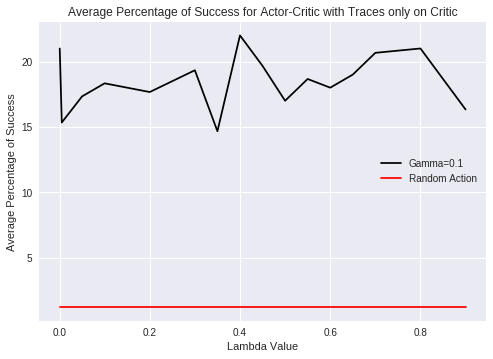

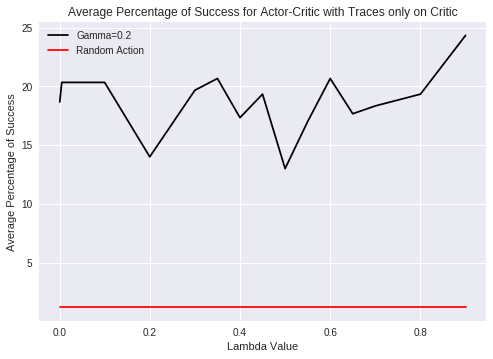

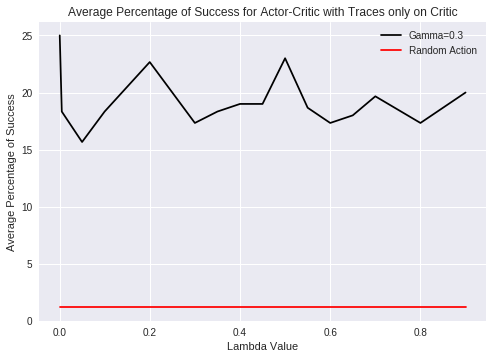

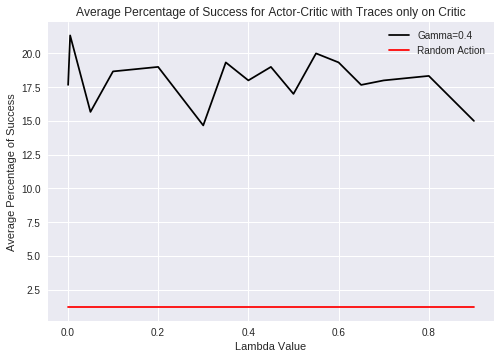

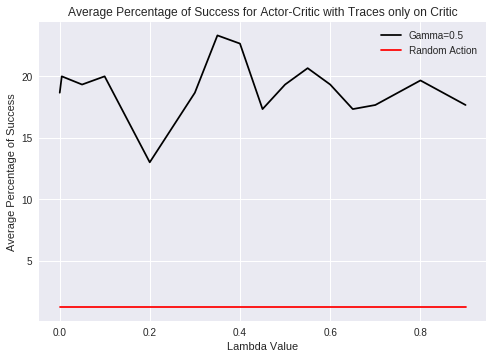

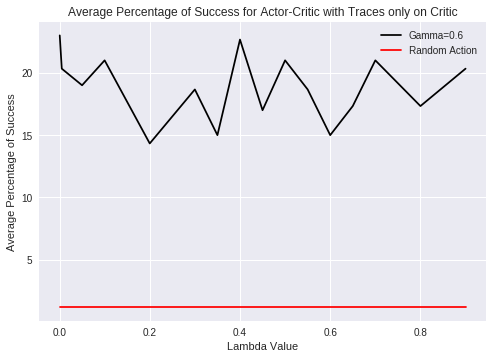

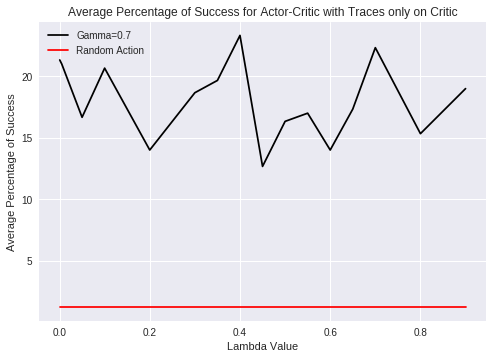

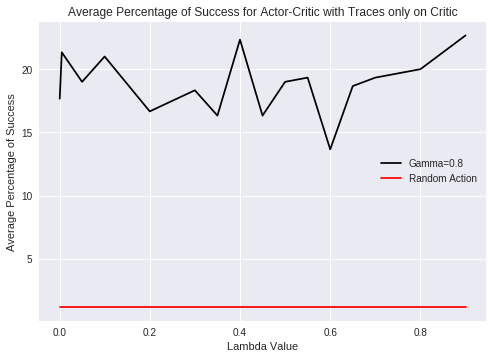

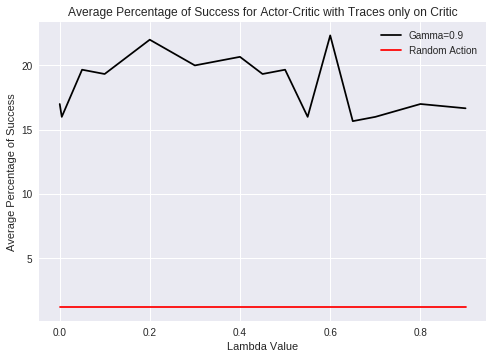

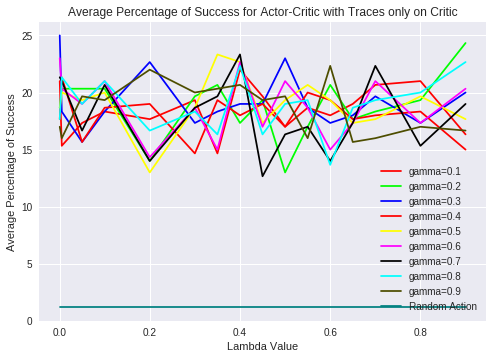

In [123]:
overall_avg_v1=np.zeros([gamma.size,lambda_theta.size])
for g in range(gamma.size):
  overall_avg_v1=overall_avg_v1+average_success_v1[g,:,:]
overall_avg_v1/number_of_runs_for_average
for g in range(gamma.size):
  plt.figure()
  plt.plot(lambda_theta.flatten(),overall_avg_v1[g,:].flatten(),label="Gamma={}".format(gamma[g]),color=(0,0,0))
  plt.plot(lambda_theta.flatten(),rr.flatten(),label="Random Action",color=(1,0,0))
  plt.title('Average Percentage of Success for Actor-Critic with Traces only on Critic')
  plt.xlabel('Lambda Value')
  plt.ylabel('Average Percentage of Success')
  plt.legend()
  plt.show()

plt.figure()
plt.plot(lambda_theta.flatten(),overall_avg_v1[0,:].flatten(),label="gamma={}".format(gamma[0]),color=(1,0,0))
plt.plot(lambda_theta.flatten(),overall_avg_v1[1,:].flatten(),label="gamma={}".format(gamma[1]),color=(0,1,0))
plt.plot(lambda_theta.flatten(),overall_avg_v1[2,:].flatten(),label="gamma={}".format(gamma[2]),color=(0,0,1))
plt.plot(lambda_theta.flatten(),overall_avg_v1[3,:].flatten(),label="gamma={}".format(gamma[3]),color=(1,0,0))
plt.plot(lambda_theta.flatten(),overall_avg_v1[4,:].flatten(),label="gamma={}".format(gamma[4]),color=(1,1,0))
plt.plot(lambda_theta.flatten(),overall_avg_v1[5,:].flatten(),label="gamma={}".format(gamma[5]),color=(1,0,1))
plt.plot(lambda_theta.flatten(),overall_avg_v1[6,:].flatten(),label="gamma={}".format(gamma[6]),color=(0,0,0))
plt.plot(lambda_theta.flatten(),overall_avg_v1[7,:].flatten(),label="gamma={}".format(gamma[7]),color=(0,1,1))
plt.plot(lambda_theta.flatten(),overall_avg_v1[8,:].flatten(),label="gamma={}".format(gamma[8]),color=(0.3,0.3,0))
plt.plot(lambda_theta.flatten(),rr.flatten(),label="Random Action",color=(0,0.5,0.5))
plt.title('Average Percentage of Success for Actor-Critic with Traces only on Critic')
plt.xlabel('Lambda Value')
plt.ylabel('Average Percentage of Success')
plt.legend()
plt.show()

### 2.3 Actor-Critic Without Any Trace Using One-Step Returns
This algorithm is also very similar to our first algorithm but without any traces. The algorithm below can also be found in [Sattun and Barto](http://incompleteideas.net/book/the-book-2nd.html) page $274$ with the title of "*One-Step Actor-Critic (episodic)*".

In [0]:
def actor_critic_F_v2(gamma,lambda_theta,lambda_w,alpha_theta,alpha_w,theta,w,environment):
  total_reward=0
  env = gym.make(environment).env
  observation_old = env.reset()
  I=1
  for t in range(200):
    x_old=np.append(1,observation_old)    
    action=choos_action(action4_softmax(x_old,theta))
    if action==0:
      action_f=np.array([1,0,0,0])
    if action==1:
      action_f=np.array([0,1,0,0])
    if action==2:
      action_f=np.array([0,0,1,0])
    if action==3:
      action_f=np.array([0,0,0,1])      
    observation_new, reward, done, info = env.step(action)
    total_reward=total_reward+reward
    x_new=np.append(1,observation_new)
    if done:
      delta=reward-np.dot(x_old,w)
    else:
      delta=reward+gamma*(np.dot(x_new,w))-np.dot(x_old,w)
    w=w+alpha_w*I*delta*I*x_old
    theta=theta+alpha_theta*I*delta*(np.append(x_old,action_f)-action4_softmax(x_old,theta)[0]*np.append(x_old,np.array([1,0,0,0]))
                                          -action4_softmax(x_old,theta)[1]*np.append(x_old,np.array([0,1,0,0]))
                                         -action4_softmax(x_old,theta)[2]*np.append(x_old,np.array([0,0,1,0]))
                                         -action4_softmax(x_old,theta)[3]*np.append(x_old,np.array([0,0,0,1])))
    I=gamma*I
    observation_old=observation_new
    if done:
      #print("Episode finished after {} timesteps".format(t+1))
      break
  return theta,w,total_reward

#### 2.3.1 Training
Below we are going to train our model for $300$ episodes on a set of $\gamma$ and $\lambda$ values indicated below. For each pair of $\gamma$ and $\lambda$ we will train our model $10$ times and then take an average to see what percentage of success the pair provides. The percentage of success is computed over the entire $300$ training steps. The model with the highest rate of success during training is preferable since it spends more time providing us with optimal solutions, rather than adjusting its parameters.

In [108]:
gamma=np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
lambda_theta=np.array([0.0005,0.005,0.05,0.1,0.2,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.8,0.9])
lambda_w=lambda_theta
alpha_theta=2**-9
alpha_w=2**-6
environment="FrozenLake-v0"
number_of_episods=300
number_of_runs_for_average=10
average_success_v2=np.zeros([number_of_runs_for_average,gamma.size,lambda_theta.size])
rr=np.zeros(lambda_theta.size)+random_result

for n in range(number_of_runs_for_average):
  print("processing: ",((n+1)*100)/number_of_runs_for_average,"% of the work")
  for g in range(gamma.size):
    for l in range (lambda_theta.size):
      t_r=0 
      theta=np.zeros(6)
      w=np.zeros(2)
      for i in range(number_of_episods):
        theta,w,temp=actor_critic_F_v2(gamma[g],lambda_theta[l],lambda_w[l],alpha_theta,alpha_w,theta,w,environment)
        t_r+=temp
      t_r=(t_r*100)/number_of_episods
      average_success_v2[n,g,l]=t_r

processing:  10.0 % of the work
processing:  20.0 % of the work
processing:  30.0 % of the work
processing:  40.0 % of the work
processing:  50.0 % of the work
processing:  60.0 % of the work
processing:  70.0 % of the work
processing:  80.0 % of the work
processing:  90.0 % of the work
processing:  100.0 % of the work


#### 2.3.2 Plots
Below we will graph some plots that we will later on refer to in the *Conclusion* section.

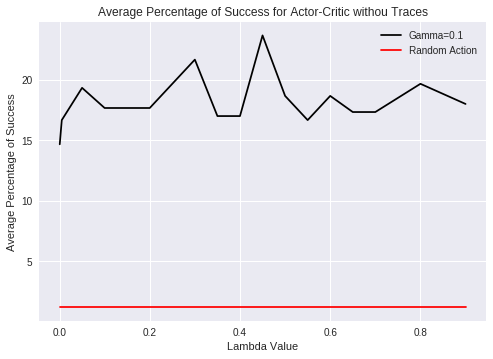

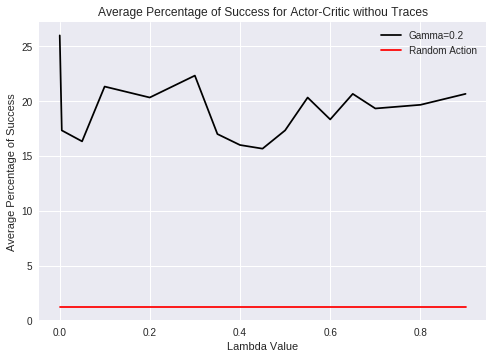

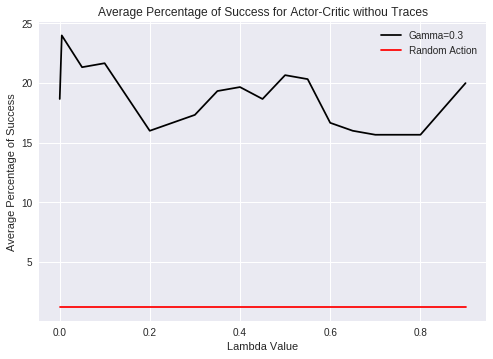

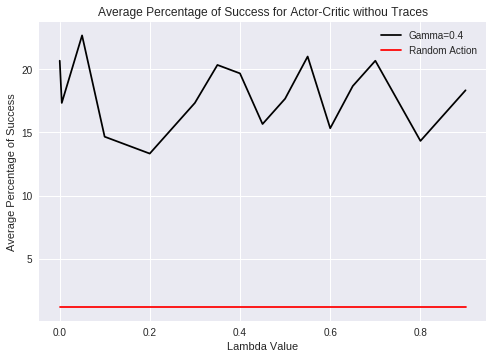

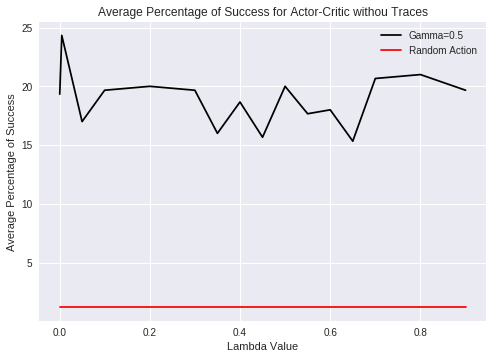

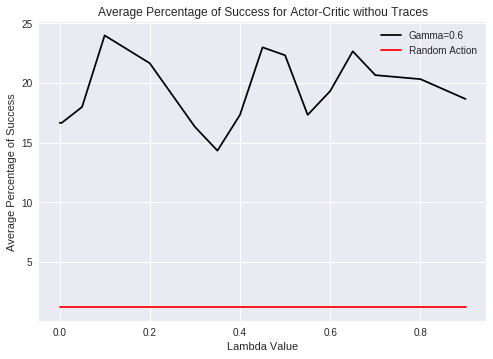

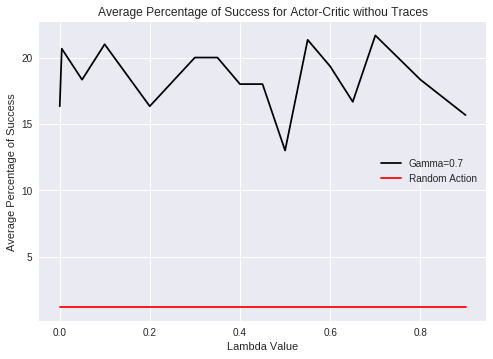

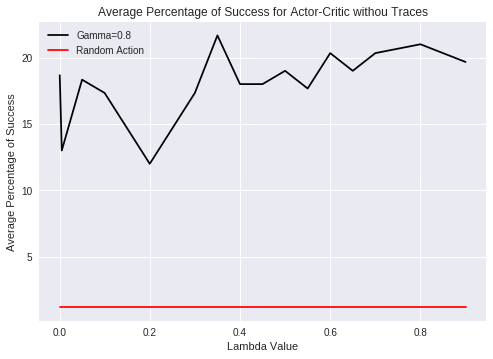

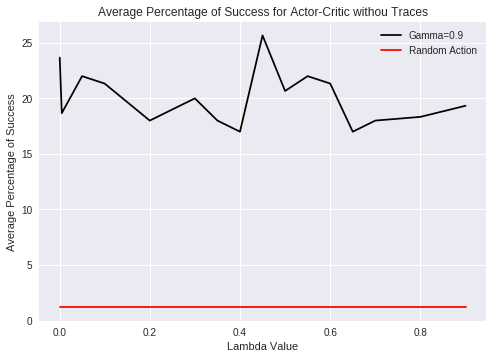

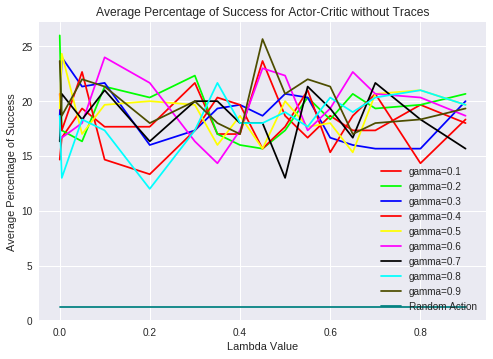

In [124]:
overall_avg_v2=np.zeros([gamma.size,lambda_theta.size])
for g in range(gamma.size):
  overall_avg_v2=overall_avg_v2+average_success_v2[g,:,:]
overall_avg_v2/number_of_runs_for_average
for g in range(gamma.size):
  plt.figure()
  plt.plot(lambda_theta.flatten(),overall_avg_v2[g,:].flatten(),label="Gamma={}".format(gamma[g]),color=(0,0,0))
  plt.plot(lambda_theta.flatten(),rr.flatten(),label="Random Action",color=(1,0,0))
  plt.title('Average Percentage of Success for Actor-Critic withou Traces')
  plt.xlabel('Lambda Value')
  plt.ylabel('Average Percentage of Success')
  plt.legend()
  plt.show()

plt.figure()
plt.plot(lambda_theta.flatten(),overall_avg_v2[0,:].flatten(),label="gamma={}".format(gamma[0]),color=(1,0,0))
plt.plot(lambda_theta.flatten(),overall_avg_v2[1,:].flatten(),label="gamma={}".format(gamma[1]),color=(0,1,0))
plt.plot(lambda_theta.flatten(),overall_avg_v2[2,:].flatten(),label="gamma={}".format(gamma[2]),color=(0,0,1))
plt.plot(lambda_theta.flatten(),overall_avg_v2[3,:].flatten(),label="gamma={}".format(gamma[3]),color=(1,0,0))
plt.plot(lambda_theta.flatten(),overall_avg_v2[4,:].flatten(),label="gamma={}".format(gamma[4]),color=(1,1,0))
plt.plot(lambda_theta.flatten(),overall_avg_v2[5,:].flatten(),label="gamma={}".format(gamma[5]),color=(1,0,1))
plt.plot(lambda_theta.flatten(),overall_avg_v2[6,:].flatten(),label="gamma={}".format(gamma[6]),color=(0,0,0))
plt.plot(lambda_theta.flatten(),overall_avg_v2[7,:].flatten(),label="gamma={}".format(gamma[7]),color=(0,1,1))
plt.plot(lambda_theta.flatten(),overall_avg_v2[8,:].flatten(),label="gamma={}".format(gamma[8]),color=(0.3,0.3,0))
plt.plot(lambda_theta.flatten(),rr.flatten(),label="Random Action",color=(0,0.5,0.5))
plt.title('Average Percentage of Success for Actor-Critic without Traces')
plt.xlabel('Lambda Value')
plt.ylabel('Average Percentage of Success')
plt.legend()
plt.show()

## 3.  Conclusion
We observe that all $3$ methods perform well. However if we focus on which method did best within the $300$ episods of their training in terms of the percentage of the time they accomplished the goal in the FrozenLake problem then we need to choose the last method, i.e. the **"Actor-Critic method without any Traces"**. We can see this by comparing the results of the plotting sections for each of these algorithms. The best performance for these algorithms was achieved:


1.   Actor-Critic with Traces: Average of $25$ for $\lambda=0.6$ and $\gamma=0.7$
2.   Actor-Critic with Traces only on the Critic: Average of $25$ for $\lambda=0.0005$ and $\gamma=0.3$
3.   Actor-critic without Traces: Average of $26$ for $\lambda=0.0005$ and $\gamma=0.2$

The effect of $\gamma$ and $\lambda$ can be studied from the plots provided in the **Plot** section of each method. We can see that for each pair of $\gamma$ and $\lambda$ the algorithm performs differently but the effect is much more present in the first algorithm. For the second and third algorithm the change in these values seems to have a lower variance over the optimal outcomes based on the graphs we have.

Note that these conclusions were made only on $300$ training iterations and averaging for only $10$ samples. A better estimate and hence a better conclusion could be drawn with more training and more samples of training to average over, however due to limited computational powers we had to settle for these numbers.

Also note that, the conclusion we reached here may change if one simply runs the above code due to the stochastic nature of the problem. In this problem as mentioned at the very beginning of this report once the agent takes an action, it does not necessarily result into that action. For example if the agent moves right, it might actually move left instead. (The frozen lake is slippery, and although the agent might act to move in a certain direction, he may slip and move in another direction)

Our last note is regarding the models we chose for the **Actor** and the **Critic** functions. We chose basic, simple linear models. Hence an exceptional performance would be too much to ask, yet our methods do perform well ($25$ times better than acting random). We could improve our methods for this problem by implementing more sophisticated **Actor** and **Critic** functions, such as **Neural Network**. However that would turn our computations even more costly and we could not afford it.

Our final comment is regarding the values of $\alpha_\theta$ and $\alpha_w$ chosen to be $2^{-9}$ and $2^{-6}$ respectively. We found these values to work somewhat well via trial and error. One could possibly improve upon our methods by simply choosing a better pair of values for $\alpha_\theta$ and $\alpha_w$. In our experience bigger values of $\alpha$'s tend to diverge and should be avoided.

